<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C5NP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
import pandas as pd

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)
mod  = test.index % 5
test_add = test.loc[ mod != 0 ,:]
test_50 = test.loc[ mod == 0 ,:]

# 確保欄位一致

In [0]:
assert list(train.columns) == list(test.columns) == list(test_170.columns)

# def train,test,features,y_name

In [4]:
features = ['T10','T50','T90','N+A']
y_name = 'C5NP'
#train = train.append(test_add)[features+[y_name]]#200筆加入訓練資料
train = train[features+[y_name]]
test = test_50[features+[y_name]]#50筆測試
test_170 = test_170[features+[y_name]]#170筆測試
print(train.shape)
print(test.shape)
print(test_170.shape)

(4521, 5)
(50, 5)
(170, 5)


# describe

In [5]:
train.describe()

,T10,T50,T90,N+A,C5NP
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,95.714590,115.699359,144.485455,40.534005,1.683571
std,10.998073,6.471767,4.270403,8.321285,2.143482
min,47.100000,83.000000,121.500000,20.570000,0.000000
25%,92.300000,113.300000,142.700000,33.034000,0.169000
50%,99.400000,117.800000,144.500000,37.859000,0.942000
75%,103.800000,120.000000,146.400000,48.612000,2.090000
max,113.200000,129.800000,164.600000,69.540000,14.751000


# corr

In [6]:
train.corr()

,T10,T50,T90,N+A,C5NP
T10,1.000000,0.894282,0.239213,-0.305082,-0.936342
T50,0.894282,1.000000,0.545153,-0.412805,-0.793461
T90,0.239213,0.545153,1.000000,-0.229858,-0.147009
N+A,-0.305082,-0.412805,-0.229858,1.000000,0.236619
C5NP,-0.936342,-0.793461,-0.147009,0.236619,1.000000


In [0]:
#根據corr 選擇重要特徵
features = ['T10','T50','T90','N+A']

# kde

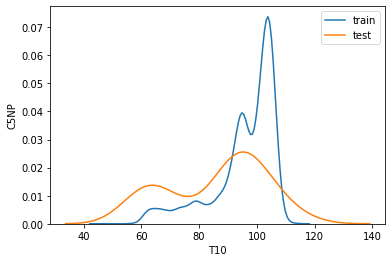

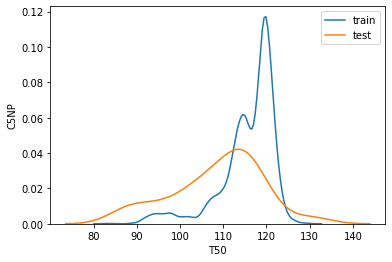

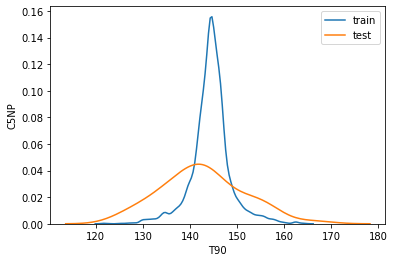

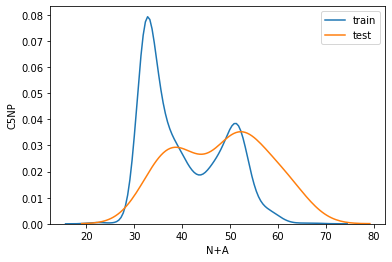

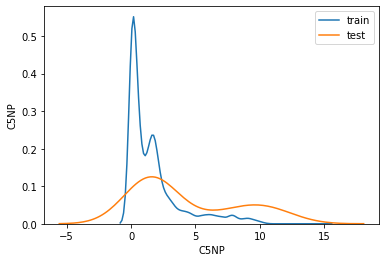

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in features+[y_name]:
  sns.kdeplot(data = train[col],label='train')
  sns.kdeplot(data = test[col],label='test')
  plt.legend();plt.xlabel(col);plt.ylabel(y_name)
  plt.show()

# scatter

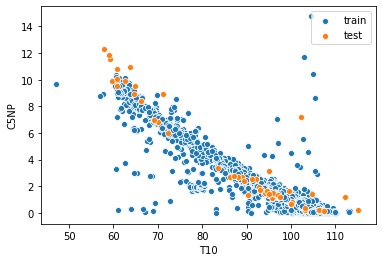

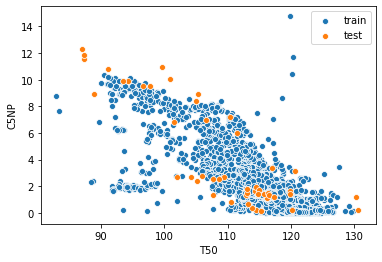

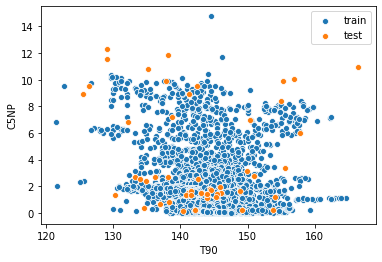

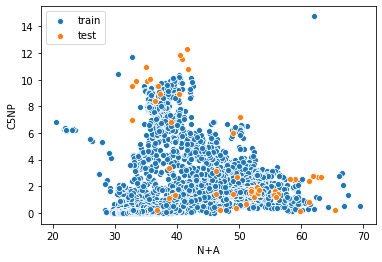

In [9]:
for x_col in features:
  sns.scatterplot(x=x_col,y=y_name,data=train,label='train')
  sns.scatterplot(x=x_col,y=y_name,data=test,label='test')
  plt.legend()
  plt.show()

# scaler

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[features].append(test[features]).append(test_170[features]))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])
test_170[features] = scaler.transform(test_170[features])

# isomap

In [0]:
from sklearn.manifold import isomap
iso = isomap.Isomap(n_components=1)
iso_col = ['T10','T50']
iso.fit(train[iso_col])
train['iso'] = iso.transform(train[iso_col])
test['iso'] = iso.transform(test[iso_col])
test_170['iso'] = iso.transform(test_170[iso_col])

# corr

In [13]:
abs(train.corr())[[y_name]].sort_values(by=y_name,ascending=False)

,C5NP
C5NP,1.000000
T10,0.936342
iso,0.849858
T50,0.793461
N+A,0.236619
T90,0.147009


# select features

In [0]:
features = ['T10','T50','T90','N+A']

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

# modeling

In [16]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
import warnings 
warnings.simplefilter('ignore')

# select model & params
#model = xgboost.XGBRegressor(objective='reg:squarederror')
model = SVR()
#model = LinearRegression()

# validate
val_scores = cross_validate(model,train[features],train[y_name],cv=5)

# print val score
print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

val_scores: [0.79401999 0.80452084 0.92583595 0.94547141 0.85448627]
val_scores.mean: 0.8648668910128361


# fit & predict

In [0]:
# fit 
model.fit(train[features],train[y_name])
# predict
train['y_pred'] = model.predict(train[features])
test['y_pred'] = model.predict(test[features])
test_170['y_pred'] = model.predict(test_170[features])

# score

In [18]:
print('train_scores:')
metric(train[y_name],train['y_pred'])

train_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.930608,0.564582,0.207196


In [19]:
print('test_250_scores:')
metric(test[y_name],test['y_pred'])

test_250_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.806754,1.7149,0.963571


In [20]:
print('test_170_scores:')
metric(test_170[y_name],test_170['y_pred'])

test_170_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.878848,0.297454,0.142609


# 準備可視化資料

In [0]:
by_col = 'T10'

In [0]:
#3 kind data
train_sample_point = train.sort_values(by=by_col)
test_point = test.sort_values(by=by_col)
test_170_point = test_170.sort_values(by=by_col)

# train line plot

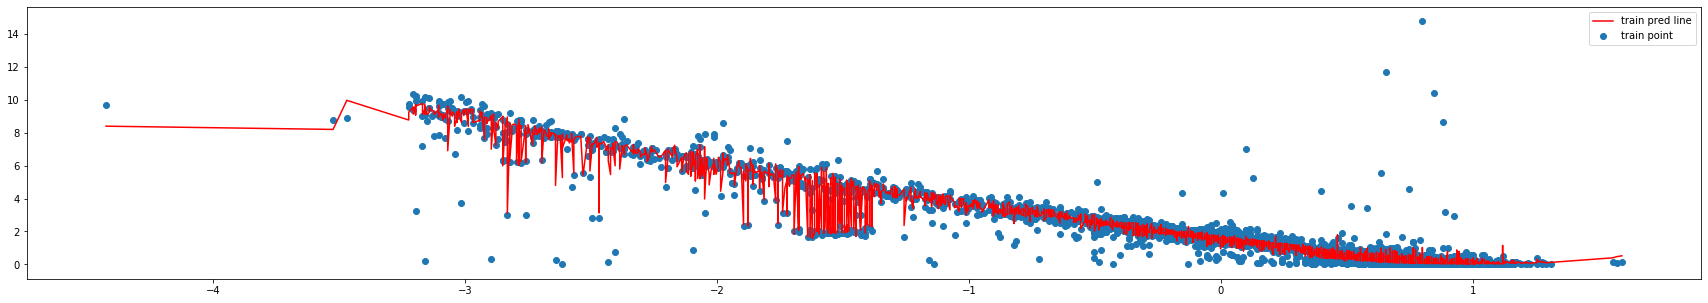

In [23]:
fig = plt.figure(figsize=(30,5))
plt.plot(train_sample_point[by_col],train_sample_point['y_pred'],label='train pred line',color='red')
plt.scatter(train_sample_point[by_col],train_sample_point[y_name],label='train point')
plt.legend()
plt.show()

# tag out

In [24]:
loss = (test_point[y_name] - test_point['y_pred'])**2 # 平方誤差
#add out columns
test_point['out'] = False
test_point.loc[loss.sort_values(ascending=False).head(1).index,'out'] = True
loss.sort_values(ascending=False).head(5)

95     44.645778
100    34.658953
90     13.158650
30     12.041985
25      6.912834
dtype: float64

In [25]:
loss = (test_170_point[y_name] - test_170_point['y_pred'])**2 # 平方誤差
test_170_point['out'] = False
test_170_point.loc[loss.sort_values(ascending=False).head(1).index,'out'] = True
loss.sort_values(ascending=False).head(5)

144    5.932928
155    1.507549
154    1.485986
153    1.109197
157    0.758964
dtype: float64

# plot out

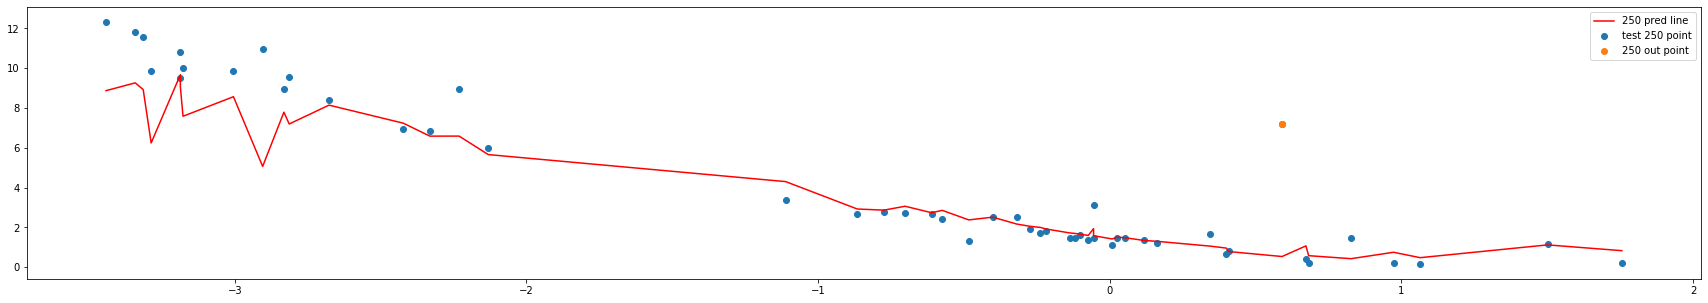

In [26]:
fig = plt.figure(figsize=(30,5))
test_point = test_point.sort_values(by=by_col)
out_point = test_point[test_point['out'] == True]
plt.plot(test_point[by_col],test_point['y_pred'],label='250 pred line',color='red')
plt.scatter(test_point[by_col],test_point[y_name],label='test 250 point')
plt.scatter(out_point[by_col],out_point[y_name],label='250 out point')
plt.legend()
plt.show()

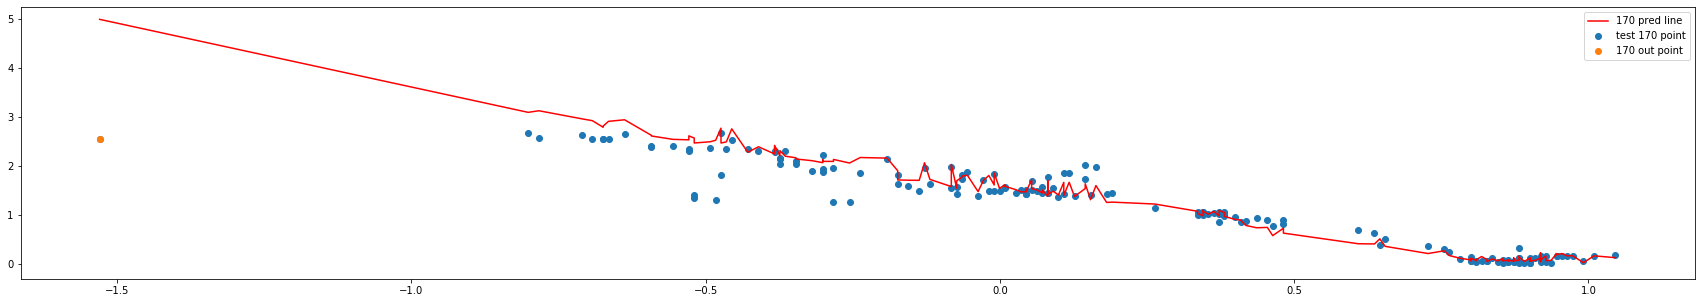

In [27]:
fig = plt.figure(figsize=(30,5))
test_170_point = test_170_point.sort_values(by=by_col)
out_170_point = test_170_point[test_170_point['out'] == True]
plt.plot(test_170_point[by_col],test_170_point['y_pred'],label='170 pred line',color='red')
plt.scatter(test_170_point[by_col],test_170_point[y_name],label='test 170 point')
plt.scatter(out_170_point[by_col],out_170_point[y_name],label='170 out point')
plt.legend()
plt.show()

# del_out_point_scores:

In [28]:
print('test 250 del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,y_name],test_point.loc[test_point['out'] == False ,'y_pred'])

test 250 del_out_point_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.863812,1.445601,0.846873


In [29]:
print('test 170 del_out_point_scores:')
metric(test_170_point.loc[test_170_point['out'] == False ,y_name],test_170_point.loc[test_170_point['out'] == False ,'y_pred'])

test 170 del_out_point_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.925437,0.232156,0.12904
